# Library

In [1]:
import gdown
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_file_id = '1z0okuNxhCYGQDBpCQ1CyOj7uT_kDHZxb'

train_output_file = '/content/train.csv'

train_download_url = f'https://drive.google.com/uc?id={train_file_id}'

gdown.download(train_download_url, train_output_file, quiet=False)

df = pd.read_csv(train_output_file, sep=';')

Downloading...
From: https://drive.google.com/uc?id=1z0okuNxhCYGQDBpCQ1CyOj7uT_kDHZxb
To: /content/train.csv
100%|██████████| 1.44M/1.44M [00:00<00:00, 73.4MB/s]


# Data Information

In [3]:
df.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [5]:
df['label'].value_counts()

,count
label,
Politik,2972
Sosial Budaya,587
Pertahanan dan Keamanan,400
Ideologi,400
Ekonomi,367
Sumber Daya Alam,192
Demografi,62
Geografi,20


# Data Cleaning

## Duplicated Data

In [6]:
df.duplicated().sum()

381

# EDA Before Preprocessing

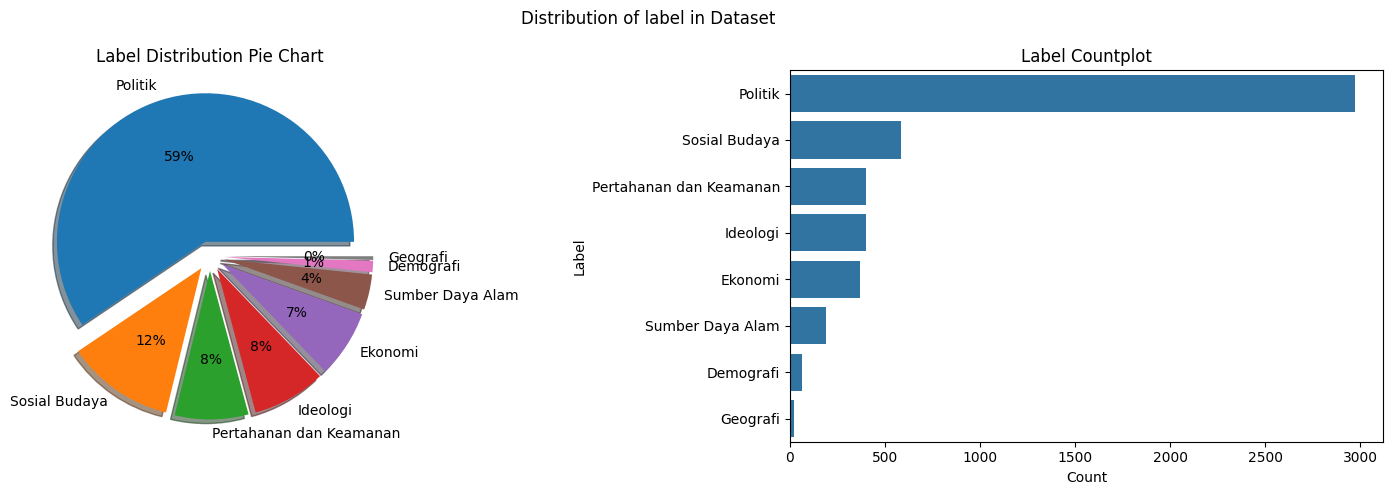

In [7]:
fig, (ax, ax1) = plt.subplots(1,2,figsize = (15,5))

ax.pie(
    df['label'].value_counts(),
    shadow = True,
    explode=[0.1 for _ in range(df['label'].nunique())],
    autopct='%1.f%%',
    labels=df['label'].value_counts().index
)

ax.set_aspect('equal')
ax.set_title('Label Distribution Pie Chart')

sns.countplot(y='label', ax=ax1, order=df['label'].value_counts().index, data=df)
ax1.set_xlabel('Count')
ax1.set_ylabel('Label')
ax1.set_title('Label Countplot')

fig.suptitle('Distribution of label in Dataset')
plt.tight_layout()
plt.show()

## Length Count

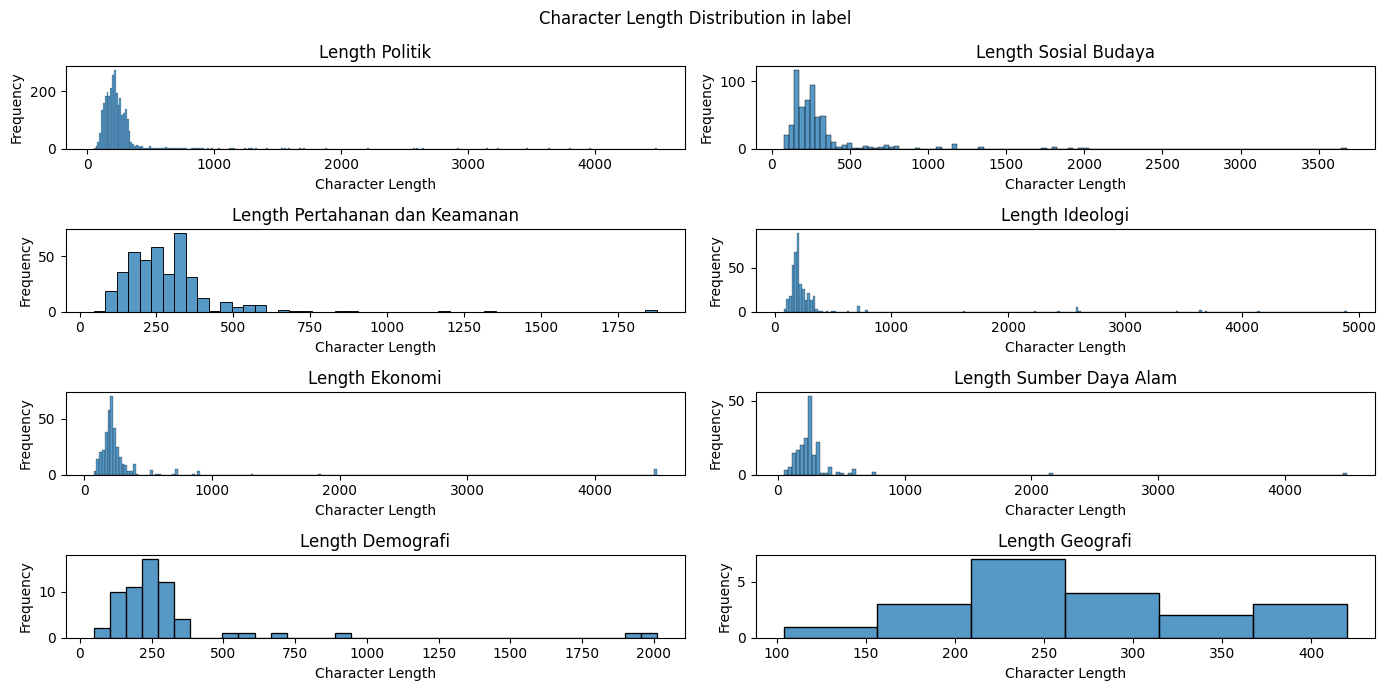

In [8]:
label = ['Politik','Sosial Budaya','Pertahanan dan Keamanan','Ideologi','Ekonomi', 'Sumber Daya Alam', 'Demografi', 'Geografi']
fig, axes = plt.subplots(4,2, figsize = (14,7))
axes = axes.flatten()

for i, col in enumerate(label):
  length_label = df[df['label'] == col]['text'].str.len()
  ax = sns.histplot(length_label, ax = axes[i])
  ax.set_title(f'Length {label[i]}')
  ax.set_xlabel('Character Length')
  ax.set_ylabel('Frequency')

fig.suptitle('Character Length Distribution in label')

plt.tight_layout()
plt.show()

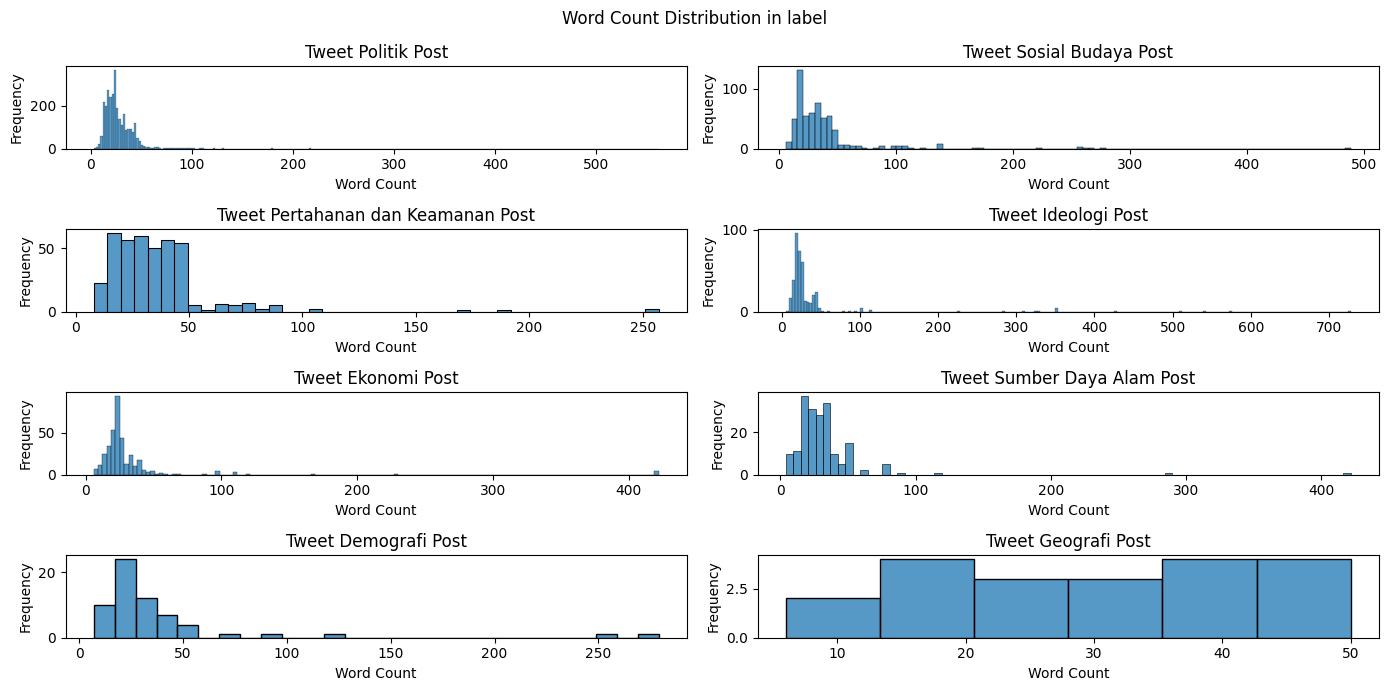

In [9]:
fig, axes = plt.subplots(4,2, figsize = (14,7))
axes = axes.flatten()

for i, col in enumerate(label):
  word_count = df[df['label'] == col]['text'].apply(lambda x: len(str(x).split()))
  ax = sns.histplot(word_count, ax=axes[i])
  ax.set_title(f'Tweet {label[i]} Post')
  ax.set_xlabel('Word Count')
  ax.set_ylabel('Frequency')

fig.suptitle('Word Count Distribution in label')

plt.tight_layout()
plt.show()

# Data Preprocessing

## Text Cleaning

In [10]:
import re
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def preprocess_text(text):
    # Menghapus RT
    text = re.sub(r'\bRT\b', '', text)
    # Menghapus teks "[RE ...]" di akhir teks
    text = re.sub(r'\[RE[^\]]*\]', '', text, flags=re.IGNORECASE)
    # Menghapus URL
    text = re.sub(r'http\S+', '', text)
    # Menghapus mention
    text = re.sub(r'@\S+', '', text)
    # Menghapus karakter non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Menghapus duplikasi karakter, misalnya '.....' menjadi '.'
    text = re.sub(r'([,.!?])\1+', r'\1', text)
    # Menghapus "amp;"
    text = re.sub(r'&amp;', '', text)
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Mengganti 'i' yang berdiri sendiri menjadi '1'
    text = re.sub(r'\bi\b', '1', text)
    # Mengganti 'ii' yang berdiri sendiri menjadi '2'
    text = re.sub(r'\bii\b', '2', text)
    # Mengganti 'iii' yang berdiri sendiri menjadi '3'
    text = re.sub(r'\biii\b', '3', text)
    # Mengganti 'xiii' yang berdiri sendiri menjadi '13'
    text = re.sub(r'\bxiii\b', '13', text)
    # Menghapus huruf berulang lebih dari 2 kali.
    text = re.sub(r'([a-zA-Z])\1{2,}', r'\1', text)
    # Memisahkan tanda baca dengan memberikan spasi sebelum atau sesudah tanda baca tersebut
    text = re.sub(r'([,.!?&\'"])', r' \1 ', text)
    # Menghapus seluruh tanda baca dari teks kecuali #
    text = re.sub(r'[^\w\s#]', '', text)
    # Mengganti kata yang mengandung angka 2 menjadi kata tanpa angka 2 menggunakan fungsi khusus
    text = replace_specific_words(text)
    # Menghapus duplikasi kata dalam satu baris teks
    words = text.split()
    seen = set()
    unique_words = []
    for word in words:
        if word not in seen:
            seen.add(word)
            unique_words.append(word)
    text = ' '.join(unique_words)

    return text

def replace_specific_words(text):
    # Fungsi untuk mengganti kata yang mengandung angka 2 menjadi kata tanpa angka 2
    def replace_match(match):
        word = match.group(0)
        # Memeriksa apakah hanya ada angka 2 di dalam kata
        if re.fullmatch(r'\w*2\w*', word) and '2' in word and not re.search(r'\d', word.replace('2', '')):
            return word.replace('2', '')
        return word

    return re.sub(r'\b\w*2\w*\b', replace_match, text)

df['text'] = df['text'].apply(preprocess_text)
df.drop_duplicates(inplace=True)
df['text'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,text
0,kunjungan prabowo ini untuk meresmikan dan men...
1,anies dapat tepuk tangan meriah saat jadi rekt...
2,emng bener sih pendukung 01 ada yg goblok begi...
3,sewaktu anies bersikap kritis ke kinerja pak p...
4,anies baswedan harap asn termasuk tni dan polr...


In [11]:
# Whitespace
df = df[df['text'].str.strip().astype(bool)]

In [12]:
df.head()

,text,label
0,kunjungan prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,anies dapat tepuk tangan meriah saat jadi rekt...,Politik
2,emng bener sih pendukung 01 ada yg goblok begi...,Demografi
3,sewaktu anies bersikap kritis ke kinerja pak p...,Politik
4,anies baswedan harap asn termasuk tni dan polr...,Politik


### Removing Punctuation

In [13]:
import string
punc = string.punctuation

def remove_punctuation(text):
  result = "".join([i for i in text if i not in punc])
  return result

In [14]:
df.head()

,text,label
0,kunjungan prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,anies dapat tepuk tangan meriah saat jadi rekt...,Politik
2,emng bener sih pendukung 01 ada yg goblok begi...,Demografi
3,sewaktu anies bersikap kritis ke kinerja pak p...,Politik
4,anies baswedan harap asn termasuk tni dan polr...,Politik


## Text Processing

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df['label'].nunique()

8

### Replacing Words

In [16]:
list_kata = {
    'myuruh': 'menyuruh',
    'wrga': 'warga',
    'bbm': 'bahan bakar minyak',
    'pks': 'partai keadilan sejahtera',
    'pns': 'pegawai negeri sipil',
    'dkk': 'dan kawan-kawan',
    'hrs': 'harus',
    'sdh': 'sudah',
    'tgl': 'tanggal',
    'dg': 'dengan',
    'n': 'dan',
    'dgn': 'dengan',
    'dng': 'dengan',
    'yg': 'yang',
    'krn': 'karena',
    'krna': 'karena',
    'pd': 'pada',
    'utk': 'untuk',
    'dr': 'dari',
    'sbg': 'sebagai',
    'sbgai': 'sebagai',
    'dlm': 'dalam',
    'jg': 'juga',
    'jga': 'juga',
    'dpt': 'dapat',
    'jd': 'jadi',
    'jdi': 'jadi',
    'sj': 'saja',
    'aja': 'saja',
    'dn': 'dan',
    'tdk': 'tidak',
    'ga': 'tidak',
    'gak': 'tidak',
    'gk': 'tidak',
    'ngga': 'tidak',
    'engga': 'tidak',
    'kagak': 'tidak',
    'ngk': 'tidak',
    'sll': 'selalu',
    'slalu': 'selalu',
    'stlh': 'setelah',
    'tp': 'tapi',
    'tpi': 'tapi',
    'hnya': 'hanya',
    'klo': 'kalau',
    'kl': 'kalau',
    'kalo': 'kalau',
    'skrg': 'sekarang',
    'skrng': 'sekarang',
    'skarang': 'sekarang',
    'skrang': 'sekarang',
    'ksh': 'kasih',
    'blm': 'belum',
    'lum': 'belum',
    'liat': 'lihat',
    'blg': 'bilang',
    'jgn': 'jangan',
    'mrk': 'mereka',
    'mrka': 'mereka',
    'lg': 'lagi',
    'knp': 'kenapa',
    'thd': 'terhadap',
    'bhw': 'bahwa',
    'adh': 'adalah',
    'adlh': 'adalah',
    'lwt': 'melalui',
    'sdh': 'sudah',
    'ad': 'ada',
    'tsb': 'tersebut',
    'hrs': 'harus',
    'ttg': 'tentang',
    'sgt': 'sangat',
    'sgala': 'segala',
    'sblm': 'sebelum',
    'sblum': 'sebelum',
    'jwbn': 'jawaban',
    'org': 'orang',
    'orng': 'orang',
    'orangk': 'orang',
    'spt': 'seperti',
    'bslah': 'bisalah',
    'bs': 'bisa',
    'bsa': 'bisa',
    'cmn': 'cuman',
    'sm': 'sama',
    'ama': 'sama',
    'bkl': 'bakal',
    'dkt': 'dekat',
    'deket': 'dekat',
    'spy': 'supaya',
    'tau': 'tahu',
    'mlh': 'malah',
    'pstinya': 'pastinya',
    'drpd': 'daripada',
    'bknkah': 'bukankah',
    'kepengen': 'mau',
    'pengen': 'mau',
    'skedar': 'sekedar',
    'nampak': 'tampak',
    'pnh': 'pernah',
    'ujan': 'hujan',
    'bgni': 'begini',
    'bgini': 'begini',
    'emng': 'memang',
    'mmg': 'memang',
    'emang': 'memang',
    'emg': 'memang',
    'rmh': 'rumah',
    'perpus': 'perpustakaan',
    'klean': 'kalian',
    'mndorong': 'mendorong',
    'mnjdi': 'menjadi',
    'neruin': 'meneruskan',
    'kmrn': 'kemarin',
    'gede': 'besar',
    'beritau': 'beritahu',
    'berpoltikan': 'politik',
    'indo': 'indonesia',
    'tomkang': 'tongkang',
    'kebtuhan': 'kebutuhan',
    'mnunjang': 'menunjang',
    'adek': 'adik',
    'sy': 'saya',
    'gua': 'saya',
    'gue': 'saya',
    'gw': 'saya',
    'w': 'saya',
    'doi': 'dia',
    'ia': 'dia',
    'elu': 'anda',
    'duo': 'dua',
    'bener': 'benar',
    'sempet': 'sempat',
    'trnyata': 'ternyata',
    'koprasi': 'koperasi',
    'brunya': 'barunya',
    'mualem': 'malam',
    'pulpres': 'pilpres',
    'dibenerin': 'diperbaiki',
    'pas': 'ketika',
    'ruar': 'luar',
    'ngehe': 'absurd',
    'menstop': 'memberhentikan',
    'jogyakarta': 'yogyakarta',
    'jkt': 'jakarta',
    'jkrta': 'jakarta',
    'jateng': 'jawa tengah',
    'jabar': 'jawa barat',
    'jatim': 'jawa timur',
    'kalteng': 'kalimantan tengah',
    'kaltim': 'kalimantan timur',
    'kalbar': 'kalimantan barat',
    'sumbar': 'sumatera barat',
    'aniess': 'anies',
    'park ahn nis': 'anies',
    'duren': 'imin',
    'imin': 'muhaimin',
    'amin': 'anis muhaimin',
    'jkw': 'jokowi',
    'jk': 'jokowi',
    'owi': 'jokowi',
    'bowok': 'prabowo',
    '0-0': 'prabowo',
    'bowo': 'prabowo',
    'prab': 'prabowo',
    'ayahbowo': 'prabowo',
    'prabs': 'prabowo',
    'wo': 'prabowo',
    'pbwogbran': 'prabowo gibran',
    'pbowogbrn': 'prabowo gibran',
    'pbowogbran': 'prabowo gibran',
    'masbowogbran': 'prabowo gibran',
    'badut gemoi': 'prabowo',
    'ahy': 'agus harimurti yudhoyono',
    'gam': 'ganjar mahfud',
    'ganjar-mahfud': 'ganjar mahfud',
    'm3ndukung': 'mendukung',
    'm3nddukung': 'mendukung',
    'm3nang': 'menang',
    'g3opolitik': 'geopolitik',
    'd3mokrasi': 'demokrasi',
    'samud3ra': 'samudera',
    'sib3r': 'siber',
    'm3nangkan': 'menangkan',
    'int3rnet': 'internet',
    'sats3t': 'satset',
    'capr3s': 'capres',
    'd3sa': 'desa',
    '3nergi': 'energi',
    'p3mimpin': 'pemimpin',
    'umkm': 'usaha mikro kecil dan menengah',
    'tni': 'tentara negara indonesia',
    'polri': 'polisi republik indonesia',
    'asn': 'aparatur sipil negara',
    'apbd': 'anggaran pendapatan dan belanja daerah',
    'kemenhan': 'kementrian pertahanan',
    'kemhan': 'kementrian pertahanan',
    'menhan': 'menteri pertahanan',
    'satgas': 'satuan pengawas',
    'unhan': 'universitas pertahanan',
    'tpd': 'tim pemenangan daerah',
    'bacaleg': 'bakal calon legislatif',
    'cawapres': 'calon wakil presiden',
    'puspolkam': 'pusat politik dan keamanan',
    'menpan': 'menteri pendayagunaan aparatur negara',
    'pom': 'polisi militer',
    'marinir': 'angkatan laut',
    'satpol': 'satuan polisi',
    'paswal': 'pasukan pengawal',
    'sosmed': 'sosial media',
    'persatuan ulama': 'persatuan ulama',
    'kpu': 'komisi pemilihan umum',
    'fraksi': 'faksi',
    'pemilu': 'pemilihan umum',
    'pan': 'partai amanat nasional',
    'koalisi': 'koalisi',
    'pdip': 'partai demokrasi indonesia perjuangan',
    'nasdem': 'nasional demokrat',
    'lurah': 'kepala desa',
    'camat': 'kepala kecamatan',
    'bupati': 'kepala daerah',
    'gubernur': 'kepala daerah',
    'walikota': 'kepala daerah'
}

def replace_words(text, replacements):
  words = text.split()
  replaced_words = [replacements.get(word, word) for word in words]
  replaced_text = ' '.join(replaced_words)
  return replaced_text

df['text'] = df['text'].apply(lambda x: replace_words(x, list_kata))
df.head()

,text,label
0,kunjungan prabowo ini untuk meresmikan dan men...,7
1,anies dapat tepuk tangan meriah saat jadi rekt...,5
2,memang benar sih pendukung 01 ada yang goblok ...,0
3,sewaktu anies bersikap kritis ke kinerja pak p...,5
4,anies baswedan harap aparatur sipil negara ter...,5


In [17]:
# Geografi
df.at[288, 'label'] = "Politik"
df.at[1917, 'label'] = "Politik"
df.at[2324, 'label'] = "Politik"
# [225, 288, 497, 777, 859, 1088, 1465, 1837, 1917, 2280, 2324, 2469, 2554, 2642, 2998, 3190, 3256, 3561, 3815]

# Demografi
df.at[968, 'label'] = "Sosial Budaya"
df.at[1236, 'label'] = "Politik"
df.at[1467, 'label'] = "Politik"
df.at[1817, 'label'] = "Politik"
df.at[2164, 'label'] = "Politik"
df.at[3458, 'label'] = "Geografi"
# [2, 63, 340, 471, 559, 594, 624, 672, 719, 776, 844, 845, 857, 926, 968, 991, 1067, 1150, 1236, 1253, 1265, 1398, 1458, 1467, 1496, 1572, 1706, 1772, 1777, 1817, 1846, 1944, 2016, 2063, 2155, 2164, 2212, 2266, 2408, 2427, 2594, 2607, 2624, 2705, 2811, 3024, 3090, 3220, 3458, 3546, 3573, 3619, 3665, 3897, 3978, 4031, 4228]

# Sumber Daya Alam
df.at[731, 'label'] = "Politik"
df.at[897, 'label'] = "Pertahanan dan Keamanan"
df.at[902, 'label'] = "Politik"
df.at[955, 'label'] = "Politik"
df.at[1015, 'label'] = "Politik"
df.at[1085, 'label'] = "Politik"
df.at[1338, 'label'] = "Pertahanan dan Keamanan"
df.at[1557, 'label'] = "Politik"
df.at[1589, 'label'] = "Demografi"
df.at[1773, 'label'] = "Politik"
df.at[1774, 'label'] = "Demografi"
df.at[1810, 'label'] = "Geografi"
df.at[1815, 'label'] = "Politik"
df.at[1937, 'label'] = "Politik"
df.at[1957, 'label'] = "Politik"
df.at[1959, 'label'] = "Politik"
df.at[1990, 'label'] = "Politik"
df.at[2192, 'label'] = "Pertahanan dan Keamanan"
df.at[2369, 'label'] = "Politik"
df.at[2422, 'label'] = "Politik"
df.at[2575, 'label'] = "Politik"
df.at[2577, 'label'] = "Politik"
df.at[2932, 'label'] = "Ideologi"
df.at[2936, 'label'] = "Politik"
df.at[3215, 'label'] = "Politik"
df.at[3318, 'label'] = "Politik"
df.at[3421, 'label'] = "Ideologi"
df.at[3460, 'label'] = "Politik"
df.at[3505, 'label'] = "Geografi"
df.at[3938, 'label'] = "Geografi"
df.at[4144, 'label'] = "Sosial Budaya"
df.at[4186, 'label'] = "Politik"
df.at[4194, 'label'] = "Politik"
df.at[4221, 'label'] = "Ekonomi"

<ipython-input-17-d1d9ff1207f5>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Politik' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[288, 'label'] = "Politik"


### Tokenization

In [18]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

df['text'] = df['text'].astype(str)

def tokenize(text):
  token = word_tokenize(text)
  return token

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
df['text'] = df['text'].apply(tokenize)
df.head()

,text,label
0,"[kunjungan, prabowo, ini, untuk, meresmikan, d...",7
1,"[anies, dapat, tepuk, tangan, meriah, saat, ja...",5
2,"[memang, benar, sih, pendukung, 01, ada, yang,...",0
3,"[sewaktu, anies, bersikap, kritis, ke, kinerja...",5
4,"[anies, baswedan, harap, aparatur, sipil, nega...",5


## Stopwords

In [20]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + stopwords.words('indonesian'))
stop_words.update(['ga', 'ya', 'kalo', 'utk', 'gak', 'yg', 'w', 'sm', 'ku', 'tp', 'dgn', 'pd', 'dr', 'sbg', 'dlm', 'jg', 'dpt', 'krn', 'jd', 'nya'])

def stopword(words):
    words = [word for word in words if word not in stop_words]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
df['text'] = df['text'].apply(stopword)
df.head()

,text,label
0,"[kunjungan, prabowo, meresmikan, menyerahkan, ...",7
1,"[anies, tepuk, tangan, meriah, rektor, mewajib...",5
2,"[sih, pendukung, 01, goblok, 02, ridwan, kamil...",0
3,"[anies, bersikap, kritis, kinerja, prabowo, di...",5
4,"[anies, baswedan, harap, aparatur, sipil, nega...",5


# lemmatizer

In [22]:
df['text'] = df['text'].apply(lambda x: " ".join(x))

In [23]:
df['text']

,text
0,kunjungan prabowo meresmikan menyerahkan proye...
1,anies tepuk tangan meriah rektor mewajibkan ma...
2,sih pendukung 01 goblok 02 ridwan kamil skeman...
3,anies bersikap kritis kinerja prabowo dianggap...
4,anies baswedan harap aparatur sipil negara ten...
...,...
1937,nan
1959,nan
2192,nan
2577,nan


In [24]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.9 MB/s eta 0:00:00


In [25]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

sastrawi = StemmerFactory()
stemmer = sastrawi.create_stemmer()

def stemmer_sastrawi(text):
    return stemmer.stem(text)

In [ ]:
df['text'] = df['text'].apply(stemmer_sastrawi)
df.head()

In [ ]:
# from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# lm = WordNetLemmatizer()

# def lemmatizer(words):
#   return [lm.lemmatize(word) for word in words]

In [ ]:
# df['text'] = df['text'].apply(lemmatizer)
# df.head()

In [ ]:
# df['text'] = df['text'].apply(lambda x: " ".join(x))

### Removing Words

In [ ]:
def remove_specific_words(text, words_to_remove):
    for word in words_to_remove:
        text = re.sub(r'(\s|^){}(\s|$)'.format(re.escape(word)), ' ', text)
    return text.strip()

words_to_remove = [
    '#jaringannasionalkeumatan', 'jaringannasionalkeumatan', '#ganjarpranowopilihanumat', '#ganjarmahfudrebound', '#ganjarmahfud2024', '#l3bihbaik', 'nya', '3',
    '1', '02', 'coblos3', 'no', 'urut', 'ya', '7', '03', '#coblos3', 'mahfudlebihbaik3'
]

df['text'] = df['text'].apply(lambda x: remove_specific_words(x, words_to_remove))

## WordCloud

In [ ]:
from wordcloud import WordCloud

fig, axes = plt.subplots(4, 2, figsize=(25, 25))
axes = axes.flatten()
labels = ['Politik','Sosial Budaya','Pertahanan dan Keamanan','Ideologi','Ekonomi', 'Sumber Daya Alam', 'Demografi', 'Geografi']

for i, lab in enumerate(labels):
    opinion = ' '.join(df[df['label'] == lab]['text'])
    ax = axes[i]
    wordcloud = WordCloud(max_words=2000, width=400, height=200, collocations=False).generate(opinion)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Word Cloud for Label {lab} Tweets (With Stopwords)")

plt.tight_layout()
plt.show()

## NGRAM

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def Gram_Analysis(Corpus, Gram, N):
  Vectorizer = CountVectorizer(ngram_range=(Gram, Gram))
  ngrams = Vectorizer.fit_transform(Corpus)

  ngram_counts = ngrams.sum(axis = 0).tolist()[0]
  vocab = Vectorizer.get_feature_names_out()

  words = [(vocab[idx], count) for idx, count in enumerate(ngram_counts)]
  words = sorted(words, key=lambda x: x[1], reverse=True)
  return words[:N]

In [ ]:
fig, axes = plt.subplots(4,2, figsize = (15,15))
axes = axes.flatten()
labels = ['Politik','Sosial Budaya','Pertahanan dan Keamanan','Ideologi','Ekonomi', 'Sumber Daya Alam', 'Demografi', 'Geografi']

for i, label in enumerate(labels):
  types = df[df['label'] == label]
  words = Gram_Analysis(types["text"], 1, 20)
  Unigram = pd.DataFrame(words, columns=["Words", "Counts"])
  ax = sns.barplot(data=Unigram, x="Counts", y="Words", ax=axes[i])
  ax.set_title(f"Top Unigrams in {label} texts")
  ax.set_xlabel("Total Counts")
  ax.set_ylabel("Top Words")

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(4,2, figsize = (16,10))
axes = axes.flatten()

for i, label in enumerate(labels):
  types = df[df['label'] == label]
  words = Gram_Analysis(types["text"], 2, 20)
  Unigram = pd.DataFrame(words, columns=["Words", "Counts"])
  ax = sns.barplot(data=Unigram, x="Counts", y="Words", ax=axes[i])
  ax.set_title(f"Top Unigrams in {label} Reviews")
  ax.set_xlabel("Total Counts")
  ax.set_ylabel("Top Words")

plt.tight_layout()
plt.show()

# Modelling

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify = y)

In [ ]:
dfs = df['text'].str.split().to_list()

## EMBBED

In [ ]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 100

w2v_model = Word2Vec(sentences=dfs, vector_size=EMBEDDING_DIM, window=5, min_count=1)
len(w2v_model.wv.key_to_index)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfs)

X = tokenizer.texts_to_sequences(dfs)

In [ ]:
w2v_model.wv.vectors.shape

In [ ]:
df['word_length'] = df['text'].apply(lambda x: len(x.split()))
df['word_length'].max()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 333

X = pad_sequences(X, maxlen=maxlen)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

In [ ]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

word_index = tokenizer.word_index
embedding_vectors = get_weight_matrix(w2v_model, word_index)
embedding_vectors.shape

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

vocab_size = 9682
EMBEDDING_DIM = 100
maxlen = 255
num_classes = 8

embedding_vectors = np.random.rand(vocab_size, EMBEDDING_DIM)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=128))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
from sklearn.metrics import balanced_accuracy_score

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_acc}')

In [ ]:
plt.plot(history.history['val_acc'])

## Tf-id Vectorizer

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer()

## Hyperparameting Tuning

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import f1_score, balanced_accuracy_score
# from sklearn.model_selection import StratifiedKFold

# model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# f1_scores = []
# balanced_acc_scores = []

# for train_index, val_index in kfold.split(X_train, y_train):
#     X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
#     y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

#     X_fold_train_tfidf = tfidf.fit_transform(X_fold_train)
#     X_fold_val_tfidf = tfidf.transform(X_fold_val)

#     model.fit(X_fold_train_tfidf, y_fold_train)
#     y_fold_pred = model.predict(X_fold_val_tfidf)

#     f1 = f1_score(y_fold_val, y_fold_pred, average='macro')
#     f1_scores.append(f1)

#     balanced_acc = balanced_accuracy_score(y_fold_val, y_fold_pred)
#     balanced_acc_scores.append(balanced_acc)

# average_f1_score = np.mean(f1_scores)
# average_balanced_acc_score = np.mean(balanced_acc_scores)

# print(f"Average weighted F1 Score: {average_f1_score:.4f}")
# print(f"Average balanced accuracy score: {average_balanced_acc_score:.4f}")

# X_train_tfidf = tfidf.fit_transform(X_train)
# model.fit(X_train_tfidf, y_train)

# X_test_tfidf = tfidf.transform(X_test)
# y_pred = model.predict(X_test_tfidf)

# print("Test balanced accuracy score:", balanced_accuracy_score(y_test, y_pred))
# print("Test F1 weighted score:", f1_score(y_test, y_pred, average='macro'))